In [31]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow import keras

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
np.random.seed(2)

results_path = Path('results', 'bitcoin_prices')
if not results_path.exists():
    results_path.mkdir(parents=True)

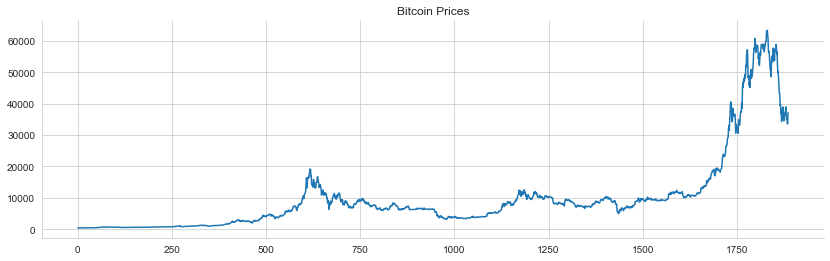

In [32]:
bitcoin = pd.read_csv('BTC_USD_2013-10-01_2021-06-10-CoinDesk.csv')

bitcoin_price = bitcoin['Closing Price (USD)']
ax = bitcoin_price.plot(title='Bitcoin Prices',
           legend=False,
           figsize=(14, 4),
           rot=0)
ax.set_xlabel('')
sns.despine()

In [33]:
scaler = MinMaxScaler()
reshaped_bitcoin = bitcoin_price.values.reshape(-1, 1)
bitcoin_scaled = pd.Series(scaler.fit_transform(reshaped_bitcoin).squeeze(), 
                           index=bitcoin_price.index)
bitcoin_scaled.describe()

count    1887.000000
mean        0.150552
std         0.199048
min         0.000000
25%         0.037734
50%         0.106817
75%         0.154292
max         1.000000
dtype: float64

In [48]:
def create_univariate_rnn_data(data, window_size):
    n = len(data)
    y = data[window_size:]
    data = data.values.reshape(-1, 1) # make 2D
    X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
    return pd.DataFrame(X, index=y.index), y

window_size = 50
X, y = create_univariate_rnn_data(bitcoin_scaled, window_size)
X.shape

(1837, 50)

In [60]:
X

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
50,0.000000,0.000049,0.000132,0.000139,0.000118,0.000130,0.000186,0.000197,0.000179,0.000166,...,0.000352,0.000395,0.000394,0.000357,0.000420,0.000460,0.000480,0.000782,0.001140,0.001557
51,0.000049,0.000132,0.000139,0.000118,0.000130,0.000186,0.000197,0.000179,0.000166,0.000284,...,0.000395,0.000394,0.000357,0.000420,0.000460,0.000480,0.000782,0.001140,0.001557,0.001777
52,0.000132,0.000139,0.000118,0.000130,0.000186,0.000197,0.000179,0.000166,0.000284,0.000408,...,0.000394,0.000357,0.000420,0.000460,0.000480,0.000782,0.001140,0.001557,0.001777,0.001893
53,0.000139,0.000118,0.000130,0.000186,0.000197,0.000179,0.000166,0.000284,0.000408,0.000456,...,0.000357,0.000420,0.000460,0.000480,0.000782,0.001140,0.001557,0.001777,0.001893,0.001748
54,0.000118,0.000130,0.000186,0.000197,0.000179,0.000166,0.000284,0.000408,0.000456,0.000463,...,0.000420,0.000460,0.000480,0.000782,0.001140,0.001557,0.001777,0.001893,0.001748,0.001915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1882,0.978054,0.955945,0.896773,0.886813,0.892926,0.853765,0.819133,0.798540,0.799567,0.764752,...,0.611755,0.608620,0.547920,0.542160,0.561454,0.580203,0.572102,0.588038,0.612446,0.584344
1883,0.955945,0.896773,0.886813,0.892926,0.853765,0.819133,0.798540,0.799567,0.764752,0.844458,...,0.608620,0.547920,0.542160,0.561454,0.580203,0.572102,0.588038,0.612446,0.584344,0.549245
1884,0.896773,0.886813,0.892926,0.853765,0.819133,0.798540,0.799567,0.764752,0.844458,0.869329,...,0.547920,0.542160,0.561454,0.580203,0.572102,0.588038,0.612446,0.584344,0.549245,0.554876
1885,0.886813,0.892926,0.853765,0.819133,0.798540,0.799567,0.764752,0.844458,0.869329,0.860870,...,0.542160,0.561454,0.580203,0.572102,0.588038,0.612446,0.584344,0.549245,0.554876,0.533913


In [49]:
X_train = X[:1700].values.reshape(-1, window_size, 1)
y_train = y[:1700]

# keep the last year for testing
X_test = X[1700:].values.reshape(-1, window_size, 1)
y_test = y[1700:]

n_obs, window_size, n_features = X_train.shape
y_train.shape

(1700,)

In [65]:
X.iloc[0]


0     0.000000
1     0.000049
2     0.000132
3     0.000139
4     0.000118
5     0.000130
6     0.000186
7     0.000197
8     0.000179
9     0.000166
10    0.000284
11    0.000408
12    0.000456
13    0.000463
14    0.000589
15    0.000644
16    0.000737
17    0.000763
18    0.000369
19    0.000447
20    0.000577
21    0.000493
22    0.000556
23    0.000407
24    0.000494
25    0.000471
26    0.000469
27    0.000648
28    0.000665
29    0.000646
30    0.000681
31    0.000577
32    0.000526
33    0.000566
34    0.000603
35    0.000604
36    0.000629
37    0.000575
38    0.000572
39    0.000563
40    0.000352
41    0.000395
42    0.000394
43    0.000357
44    0.000420
45    0.000460
46    0.000480
47    0.000782
48    0.001140
49    0.001557
Name: 50, dtype: float64

In [50]:
# Building the Model
# Needs numpy < 1.20 to work with tf 2.3.0

rnn = Sequential([
    LSTM(units=10, 
         input_shape=(window_size, n_features), name='LSTM'),
    Dense(1, name='Output')
])

rnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM (LSTM)                  (None, 10)                480       
_________________________________________________________________
Output (Dense)               (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


In [51]:
optimizer = keras.optimizers.RMSprop(lr=0.001,
                                     rho=0.9,
                                     epsilon=1e-08,
                                     decay=0.0)

rnn.compile(loss='mean_squared_error', 
            optimizer=optimizer)

rnn_path = (results_path / 'rnn.h5').as_posix()
checkpointer = ModelCheckpoint(filepath=rnn_path,
                               verbose=1,
                               monitor='val_loss',
                               save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', 
                              patience=20,
                              restore_best_weights=True)

lstm_training = rnn.fit(X_train,
                        y_train,
                        epochs=150,
                        batch_size=20,
                        shuffle=True,
                        validation_data=(X_test, y_test),
                        callbacks=[early_stopping, checkpointer],
                        verbose=1)

Epoch 1/150
80/85 [===========================>..] - ETA: 0s - loss: 0.0030
Epoch 00001: val_loss improved from inf to 0.01332, saving model to results/bitcoin_prices\rnn.h5
85/85 [==============================] - 2s 18ms/step - loss: 0.0029 - val_loss: 0.0133
Epoch 2/150
82/85 [===========================>..] - ETA: 0s - loss: 2.5322e-04
Epoch 00002: val_loss improved from 0.01332 to 0.00554, saving model to results/bitcoin_prices\rnn.h5
85/85 [==============================] - 1s 8ms/step - loss: 2.5634e-04 - val_loss: 0.0055
Epoch 3/150
78/85 [==========================>...] - ETA: 0s - loss: 2.1693e-04
Epoch 00003: val_loss improved from 0.00554 to 0.00454, saving model to results/bitcoin_prices\rnn.h5
85/85 [==============================] - 1s 9ms/step - loss: 2.0965e-04 - val_loss: 0.0045
Epoch 4/150
82/85 [===========================>..] - ETA: 0s - loss: 1.8515e-04
Epoch 00004: val_loss did not improve from 0.00454
85/85 [==============================] - 1s 9ms/step - loss: 

85/85 [==============================] - 1s 9ms/step - loss: 7.0297e-05 - val_loss: 0.0013
Epoch 35/150
84/85 [============================>.] - ETA: 0s - loss: 7.0866e-05
Epoch 00035: val_loss did not improve from 0.00127
85/85 [==============================] - 1s 8ms/step - loss: 7.0451e-05 - val_loss: 0.0016
Epoch 36/150
79/85 [==========================>...] - ETA: 0s - loss: 6.5178e-05
Epoch 00036: val_loss did not improve from 0.00127
85/85 [==============================] - 1s 8ms/step - loss: 6.7000e-05 - val_loss: 0.0015
Epoch 37/150
82/85 [===========================>..] - ETA: 0s - loss: 6.9267e-05
Epoch 00037: val_loss improved from 0.00127 to 0.00124, saving model to results/bitcoin_prices\rnn.h5
85/85 [==============================] - 1s 9ms/step - loss: 6.8533e-05 - val_loss: 0.0012
Epoch 38/150
79/85 [==========================>...] - ETA: 0s - loss: 6.2103e-05
Epoch 00038: val_loss did not improve from 0.00124
85/85 [==============================] - 1s 8ms/step - lo

Epoch 71/150
84/85 [============================>.] - ETA: 0s - loss: 5.4390e-05
Epoch 00071: val_loss did not improve from 0.00113
85/85 [==============================] - 1s 8ms/step - loss: 5.3971e-05 - val_loss: 0.0016
Epoch 72/150
84/85 [============================>.] - ETA: 0s - loss: 5.5327e-05
Epoch 00072: val_loss did not improve from 0.00113
85/85 [==============================] - 1s 8ms/step - loss: 5.5346e-05 - val_loss: 0.0022
Epoch 73/150
84/85 [============================>.] - ETA: 0s - loss: 5.3704e-05
Epoch 00073: val_loss did not improve from 0.00113
85/85 [==============================] - 1s 8ms/step - loss: 5.4405e-05 - val_loss: 0.0019
Epoch 74/150
82/85 [===========================>..] - ETA: 0s - loss: 5.3990e-05
Epoch 00074: val_loss did not improve from 0.00113
85/85 [==============================] - 1s 9ms/step - loss: 5.4370e-05 - val_loss: 0.0024
Epoch 75/150
85/85 [==============================] - ETA: 0s - loss: 5.4127e-05
Epoch 00075: val_loss did n

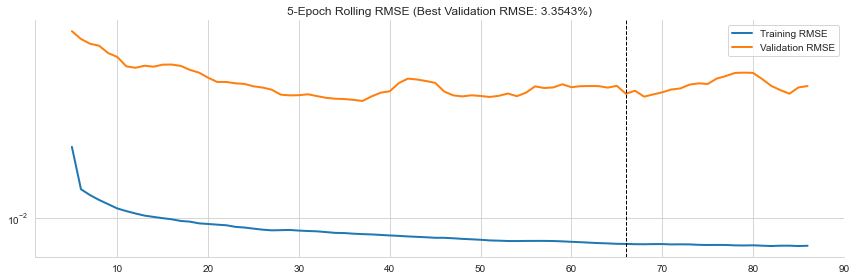

In [52]:
fig, ax = plt.subplots(figsize=(12, 4))

loss_history = pd.DataFrame(lstm_training.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'5-Epoch Rolling RMSE (Best Validation RMSE: {best_rmse:.4%})'
loss_history.columns=['Training RMSE', 'Validation RMSE']
loss_history.rolling(5).mean().plot(logy=True, lw=2, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_bitcoin_error', dpi=300);

In [53]:
train_rmse_scaled = np.sqrt(rnn.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(rnn.evaluate(X_test, y_test, verbose=0))
print(f'Train RMSE: {train_rmse_scaled:.4f} | Test RMSE: {test_rmse_scaled:.4f}')

train_predict_scaled = rnn.predict(X_train)
test_predict_scaled = rnn.predict(X_test)

train_ic = spearmanr(y_train, train_predict_scaled)[0]
test_ic = spearmanr(y_test, test_predict_scaled)[0]
print(f'Train IC: {train_ic:.4f} | Test IC: {test_ic:.4f}')

Train RMSE: 0.0079 | Test RMSE: 0.0335
Train IC: 0.9969 | Test IC: 0.9521


In [54]:
# Rescale Predictions

train_predict = pd.Series(scaler.inverse_transform(train_predict_scaled).squeeze(), index=y_train.index)
test_predict = (pd.Series(scaler.inverse_transform(test_predict_scaled)
                          .squeeze(), 
                          index=y_test.index))


y_train_rescaled = scaler.inverse_transform(y_train.to_frame()).squeeze()
y_test_rescaled = scaler.inverse_transform(y_test.to_frame()).squeeze()

train_rmse = np.sqrt(mean_squared_error(train_predict, y_train_rescaled))
test_rmse = np.sqrt(mean_squared_error(test_predict, y_test_rescaled))
print(f'Train RMSE: {train_rmse:.2f} | Test RMSE: {test_rmse:.2f}')

bitcoin_price = pd.DataFrame(bitcoin_price)
bitcoin_price['Train Predictions'] = train_predict
bitcoin_price['Test Predictions'] = test_predict

bitcoin_price_joined = bitcoin_price.join(train_predict.to_frame('predictions').assign(data='Train')
                                    .append(test_predict.to_frame('predictions').assign(data='Test')))


Train RMSE: 497.72 | Test RMSE: 2110.84


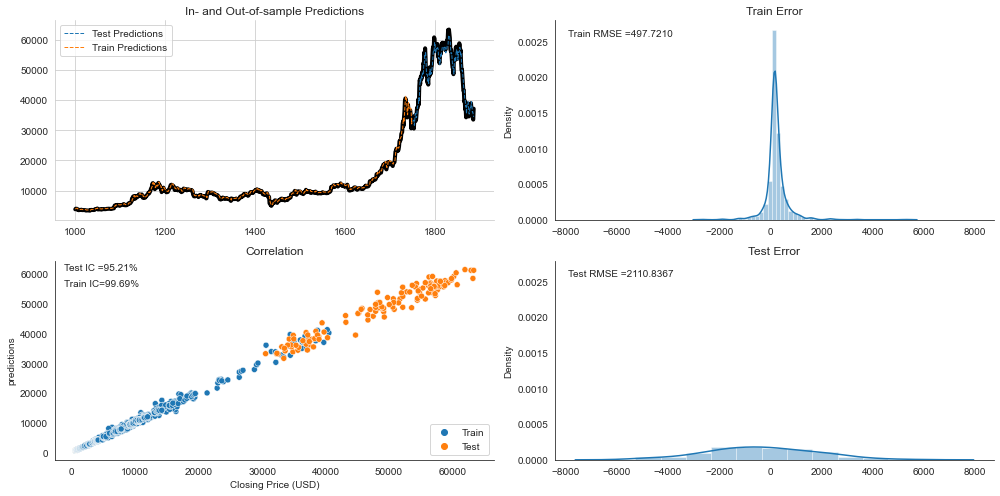

In [55]:
fig=plt.figure(figsize=(14,7))
ax1 = plt.subplot(221)

bitcoin_price_joined.loc[1000:, 'Closing Price (USD)'].plot(lw=4, ax=ax1, c='k')
bitcoin_price_joined.loc[1000:, ['Test Predictions', 'Train Predictions']].plot(lw=1, ax=ax1, ls='--')
ax1.set_title('In- and Out-of-sample Predictions')


with sns.axes_style("white"):
    ax3 = plt.subplot(223)
    sns.scatterplot(x='Closing Price (USD)', y='predictions', data=bitcoin_price_joined, hue='data', ax=ax3)
    ax3.text(x=.02, y=.95, s=f'Test IC ={test_ic:.2%}', transform=ax3.transAxes)
    ax3.text(x=.02, y=.87, s=f'Train IC={train_ic:.2%}', transform=ax3.transAxes)
    ax3.set_title('Correlation')
    ax3.legend(loc='lower right')
    
    ax2 = plt.subplot(222)
    ax4 = plt.subplot(224, sharex = ax2, sharey=ax2)
    sns.distplot(train_predict.squeeze()- y_train_rescaled, ax=ax2)
    ax2.set_title('Train Error')
    ax2.text(x=.03, y=.92, s=f'Train RMSE ={train_rmse:.4f}', transform=ax2.transAxes)
    sns.distplot(test_predict.squeeze()-y_test_rescaled, ax=ax4)
    ax4.set_title('Test Error')
    ax4.text(x=.03, y=.92, s=f'Test RMSE ={test_rmse:.4f}', transform=ax4.transAxes)

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_bitcoin_regression', dpi=300);